In [18]:
import pandas as pd 
import numpy as np 
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split

import sys
sys.path.append("../src") 
from preprocess import *

In [19]:
train_path = "../data/processed/processed_train.csv"
val_path = "../data/processed/processed_val.csv"
test_path = "../data/processed/processed_test.csv"

X_train = pd.read_csv(train_path)
X_val = pd.read_csv(val_path)
X_test = pd.read_csv(test_path)

y_train = X_train.pop("Depression")
y_val = X_val.pop("Depression")

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(random_state = 0)
xgb.fit(X_train, y_train)

prediction = xgb.predict(X_val)
#binary_prediction = (prediction >= 0.5).astype(int)

accuracy_score(y_val, prediction)

0.9363539445628998

In [21]:
params = {
    'n_estimators': [100, 200, 300],       # Number of trees
    'max_depth': [3, 6, 9],                # Tree depth
    'learning_rate': [0.01, 0.1, 0.3],     # Step size
    #'subsample': [0.6, 0.8, 1.0],          #% of samples per tree
    #'colsample_bytree': [0.6, 0.8, 1.0],   #% of features per tree
    'gamma': [0, 0.1, 0.3],                # Min loss reduction to split
    'reg_alpha': [0, 0.1, 1],              # L1 regularization
    'reg_lambda': [0, 0.1, 1]              # L2 regularization
}

In [22]:
from sklearn.model_selection import RandomizedSearchCV

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=params,
    n_iter=50,           # Number of parameter combinations
    cv=3,                # 3-fold cross-validation
    scoring='f1',        # Use F1 for imbalanced classes
    verbose=2,
    random_state=42
)

search.fit(X_train, y_train)

# Best parameters
print("Best params:", search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END gamma=0.1, learning_rate=0.3, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=0; total time=   0.6s
[CV] END gamma=0.1, learning_rate=0.3, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=0; total time=   0.6s
[CV] END gamma=0.1, learning_rate=0.3, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=0; total time=   0.6s
[CV] END gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=0.1; total time=   1.0s
[CV] END gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=0.1; total time=   1.5s
[CV] END gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=0.1; total time=   1.0s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=100, reg_alpha=0.1, reg_lambda=1; total time=   0.5s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=100, reg_alpha=0.1, reg_lambda=1; total time=   0.7

In [23]:
best_xgb = search.best_estimator_
preds = best_xgb.predict(X_val)

print(f"Tuned Accuracy: {accuracy_score(y_val, preds):.4f}")

Tuned Accuracy: 0.9394


In [24]:
pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

,Feature,Importance
13,Have you ever had suicidal thoughts ?_No,0.269085
18,Age,0.232541
2,Working Professional or Student_Student,0.158059
22,Pressure,0.079614
21,Financial Stress,0.068606
12,Dietary Habits_Unhealthy,0.037788
23,Satisfaction,0.035003
19,CGPA,0.025092
20,Work/Study Hours,0.024883
9,Dietary Habits_Healthy,0.023685


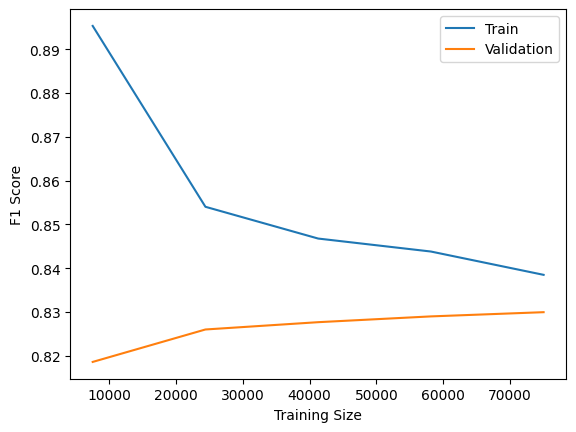

In [25]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_xgb, X_train, y_train, cv=3, scoring='f1'
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation')
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.legend()

In [26]:
test_preds = best_xgb.predict(X_test)

output = pd.DataFrame({"id": X_test.id,
                       "Depression": test_preds})
output.to_csv("../submissions/submission2.csv", index=False)